<a href="https://colab.research.google.com/github/SuperShubh/Data-Visualization-J-project/blob/main/VIS_FINAL_REVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

In [ ]:
#Count images in the two folders: yes (Tumor) and no (Healthey)
root =  '/content/drive/MyDrive/PROJECTS/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'yes': 155, 'no': 98}

Text(0.5, 1.0, 'no')

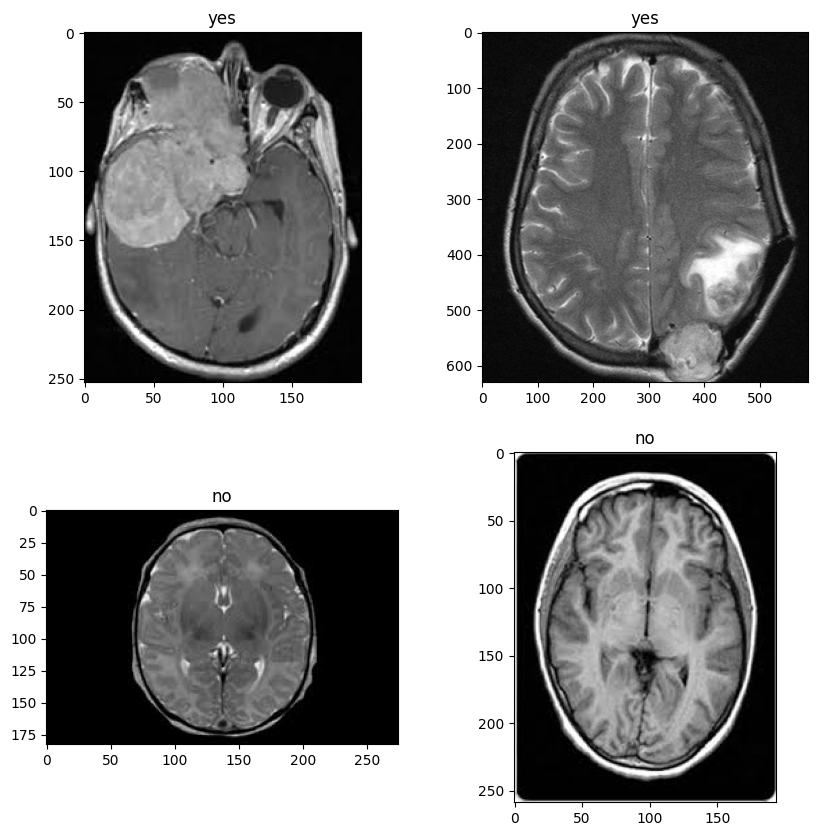

In [ ]:
#Plot some MRI images
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(load_img(os.path.join('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes', os.listdir('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes')[0])))
plt.title('yes')
plt.subplot(2, 2, 2)
plt.imshow(load_img(os.path.join('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes', os.listdir('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes')[1])))
plt.title('yes')

plt.subplot(2, 2, 3)
plt.imshow(load_img(os.path.join('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no', os.listdir('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no')[0])))
plt.title('no')
plt.subplot(2, 2, 4)
plt.imshow(load_img(os.path.join('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no', os.listdir('/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no')[1])))
plt.title('no')

In [ ]:
#Define a function that plot images
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

## ADABOOST CLASSIFIER

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = []
y = []
yes_folder="/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes"
no_folder="/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no"
for folder in [yes_folder, no_folder]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        X.append(img.flatten())
        y.append(1 if folder == yes_folder else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train AdaBoost classifier with decision tree as the base classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200, learning_rate=0.5)
clf.fit(X_train, y_train)

# Evaluate accuracy on test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7843137254901961


# VGG MODELS

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

# Load the VGG model with pre-trained weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X = []
y = []
yes_folder="/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/yes"
no_folder="/content/drive/MyDrive/PROJECTS/brain_tumor_dataset/no"
for folder in [yes_folder, no_folder]:
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.resize(img, (224, 224))
        # Convert the image to RGB format and preprocess it
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_input(img)
        X.append(img)
        y.append(1 if folder == yes_folder else 0)

# Convert the list of images to a numpy array
X = np.array(X)

X_features = vgg_model.predict(X)

X_features = X_features.reshape(X_features.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


8/8 [==============================] - 158s 20s/step
Accuracy: 0.803921568627451


# CNN MODEL

In [ ]:
#Define a function that creates new folders for the train, test and val sets and append random pictures to them based on the split percentage
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [ ]:
#Create the training set
create_folders('train', 0.7)

train Already exists


In [ ]:
#Create the test set
create_folders('test', 0.15)

test Already exists


In [ ]:
#Create the validation set
create_folders('val', 0.15)

val Already exists


In [ ]:
#Define a function that counts images in the folders: yes (Tumor) and no (Healthey)
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [ ]:
#Count images in the training set
count_img('train')

{'yes': 108, 'no': 68}

In [ ]:
count_img('test')

{'yes': 23, 'no': 14}

In [ ]:
#Count images in the validation set
count_img('val')

{'yes': 23, 'no': 14}

In [ ]:
#Define a function that crop tha brain contour
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [ ]:
import cv2

In [ ]:
#Define a function that load data
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
import os

In [ ]:
#Load trainig data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 176
X shape is: (176, 240, 240, 3)
y shape is: (176, 1)


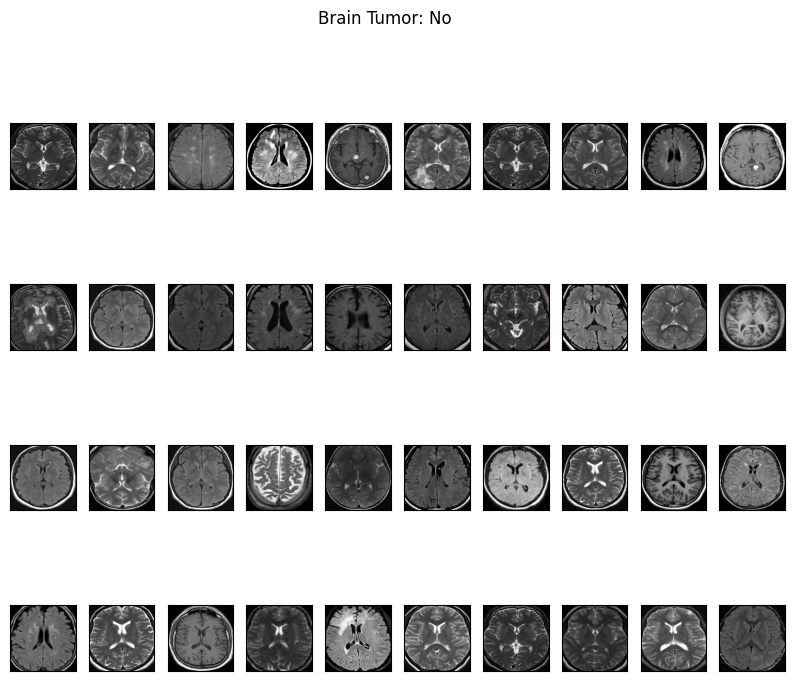

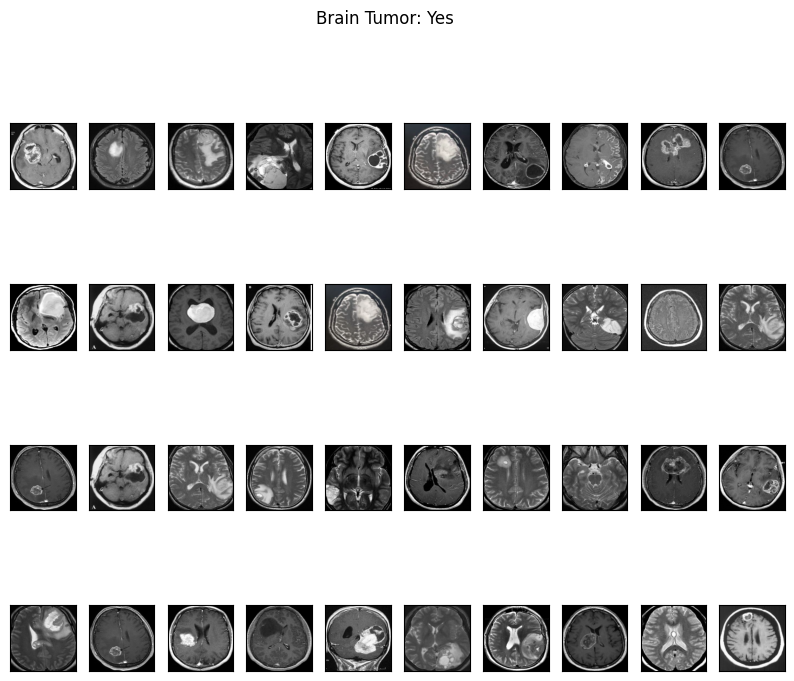

In [ ]:
#Plot samples from the training set
plot_sample_images(X_train, y_train)

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 37
X shape is: (37, 240, 240, 3)
y shape is: (37, 1)


In [ ]:
#Load validation data
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 37
X shape is: (37, 240, 240, 3)
y shape is: (37, 1)


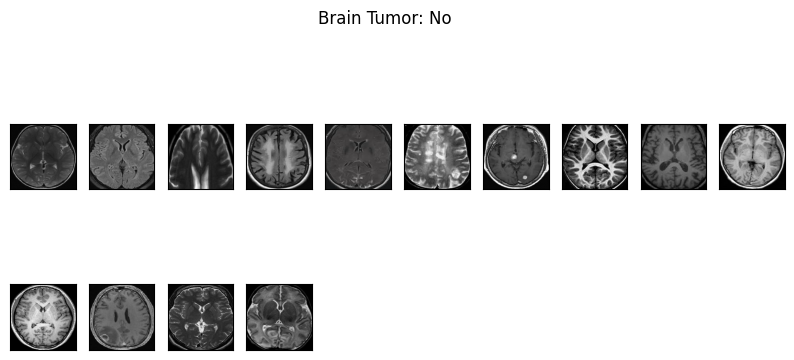

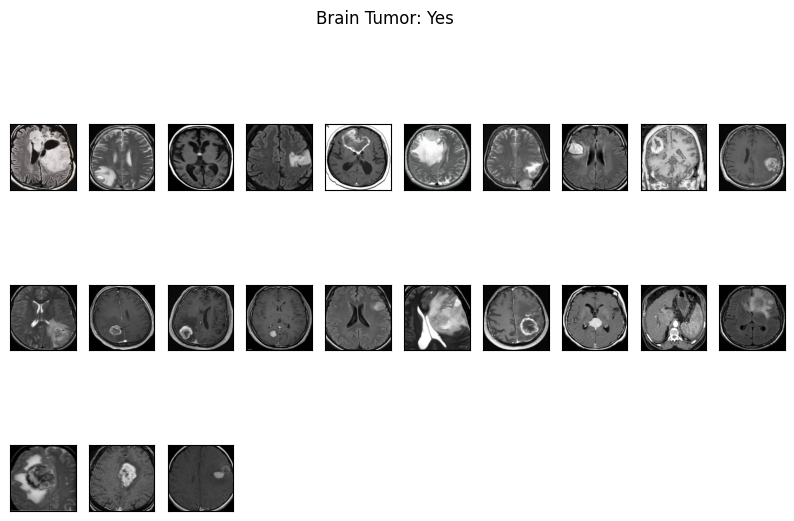

In [ ]:
#Plot samples from the validation set
plot_sample_images(X_val, y_val)

In [ ]:
#Build our model
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

#Compile our model
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

#Early stopping and model checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 118, 118, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 128)      

In [ ]:
#Train our model
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 10, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 1.0922 - accuracy: 0.4318
Epoch 1: val_accuracy improved from -inf to 0.62162, saving model to ./bestmodel.h5
6/6 [==============================] - 41s 7s/step - loss: 1.0922 - accuracy: 0.4318 - val_loss: 0.6647 - val_accuracy: 0.6216
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.6136
Epoch 2: val_accuracy did not improve from 0.62162
6/6 [==============================] - 38s 7s/step - loss: 0.6519 - accuracy: 0.6136 - val_loss: 0.6602 - val_accuracy: 0.6216
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.6420
Epoch 3: val_accuracy did not improve from 0.62162
6/6 [==============================] - 34s 6s/step - loss: 0.6343 - accuracy: 0.6420 - val_loss: 0.6838 - val_accuracy: 0.5135
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.7386
Epoch 4: val_accuracy did not improve from 0.62162
6/6 [=========

# Hybrid Models

## CNN-DWA 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Lambda, Dropout
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (240, 240, 3)

# Define the input tensor
inputs = Input(shape=input_shape)

# Define the convolutional layers
conv1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

# Define the dynamic weight averaging layer
def dynamic_weight_average(x):
    x_avg = tf.reduce_mean(x, axis=[1,2], keepdims=True)
    x_max = tf.reduce_max(x, axis=[1,2], keepdims=True)
    x = tf.concat([x_avg, x_max], axis=-1)
    return x

dwa = Lambda(dynamic_weight_average)(pool3)

# Define the fully connected layers
flatten = Flatten()(dwa)
fc1 = Dense(units=64, activation='relu')(flatten)
dropout1 = Dropout(rate=0.25)(fc1)
fc2 = Dense(units=1, activation='sigmoid')(dropout1)

# Define the model
model = Model(inputs=inputs, outputs=fc2)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy: {:.2f}%'.format(accuracy*100))


Epoch 1/10
6/6 [==============================] - 13s 2s/step - loss: 0.6854 - accuracy: 0.5625 - val_loss: 0.6568 - val_accuracy: 0.6216
Epoch 2/10
6/6 [==============================] - 12s 2s/step - loss: 0.6631 - accuracy: 0.6136 - val_loss: 0.6557 - val_accuracy: 0.6216
Epoch 3/10
6/6 [==============================] - 10s 2s/step - loss: 0.6602 - accuracy: 0.6136 - val_loss: 0.6546 - val_accuracy: 0.6216
Epoch 4/10
6/6 [==============================] - 11s 2s/step - loss: 0.6638 - accuracy: 0.6193 - val_loss: 0.6553 - val_accuracy: 0.6216
Epoch 5/10
6/6 [==============================] - 12s 2s/step - loss: 0.6616 - accuracy: 0.6136 - val_loss: 0.6556 - val_accuracy: 0.6216
Epoch 6/10
6/6 [==============================] - 11s 2s/step - loss: 0.6607 - accuracy: 0.6080 - val_loss: 0.6559 - val_accuracy: 0.6216
Epoch 7/10
6/6 [==============================] - 10s 2s/step - loss: 0.6530 - accuracy: 0.6193 - val_loss: 0.6540 - val_accuracy: 0.6216
Epoch 8/10
6/6 [==================

## CNN-SVM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Load the dataset
train_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    'train',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)
test_data = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    'test',
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'binary'
)


Found 176 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


In [ ]:
# Create a CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

# Compile the model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the model
history = model.fit(train_data, epochs = 10, validation_data = test_data)


Epoch 1/10
6/6 [==============================] - 21s 3s/step - loss: 2.5365 - accuracy: 0.5568 - val_loss: 0.8656 - val_accuracy: 0.6757
Epoch 2/10
6/6 [==============================] - 20s 4s/step - loss: 0.5446 - accuracy: 0.7841 - val_loss: 0.5857 - val_accuracy: 0.7027
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 0.3729 - accuracy: 0.8352 - val_loss: 0.5114 - val_accuracy: 0.8378
Epoch 4/10
6/6 [==============================] - 19s 3s/step - loss: 0.2632 - accuracy: 0.8977 - val_loss: 0.5542 - val_accuracy: 0.8108
Epoch 5/10
6/6 [==============================] - 18s 3s/step - loss: 0.1934 - accuracy: 0.8977 - val_loss: 0.4850 - val_accuracy: 0.8378
Epoch 6/10
6/6 [==============================] - 19s 3s/step - loss: 0.0960 - accuracy: 0.9716 - val_loss: 0.4943 - val_accuracy: 0.8378
Epoch 7/10
6/6 [==============================] - 18s 3s/step - loss: 0.0501 - accuracy: 0.9830 - val_loss: 0.5269 - val_accuracy: 0.8378
Epoch 8/10
6/6 [==================

In [ ]:
# Extract the features from the CNN model
X_train = []
y_train = []
for i in range(len(train_data)):
    x, y = train_data[i]
    X_train.append(model.predict(x))
    y_train.append(y)
X_train = np.vstack(X_train)
y_train = np.concatenate(y_train)

X_test = []
y_test = []
for i in range(len(test_data)):
    x, y = test_data[i]
    X_test.append(model.predict(x))
    y_test.append(y)
X_test = np.vstack(X_test)
y_test = np.concatenate(y_test)


1/1 [==============================] - 0s 118ms/step


In [ ]:
# Train a SVM model using the extracted features
svm = SVC(kernel = 'rbf')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Evaluate the SVM model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.83      0.71      0.77        14
         1.0       0.84      0.91      0.87        23

    accuracy                           0.84        37
   macro avg       0.84      0.81      0.82        37
weighted avg       0.84      0.84      0.83        37

[[10  4]
 [ 2 21]]


## Random Forest

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define path to the 'yes' and 'no' folders containing the MRI images
yes_path = '/content/drive/MyDrive/PROJECTS/yes'
no_path = '/content/drive/MyDrive/PROJECTS/no'

# Define image size for resizing
img_size = (240, 240)

# Load images from the 'yes' folder
yes_images = []
for filename in os.listdir(yes_path):
    img = cv2.imread(os.path.join(yes_path, filename))
    img = cv2.resize(img, img_size)
    yes_images.append(img)

# Load images from the 'no' folder
no_images = []
for filename in os.listdir(no_path):
    img = cv2.imread(os.path.join(no_path, filename))
    img = cv2.resize(img, img_size)
    no_images.append(img)

# Create labels for the images
yes_labels = np.ones(len(yes_images))
no_labels = np.zeros(len(no_images))

# Concatenate the 'yes' and 'no' images and labels into a single dataset
X = np.concatenate((yes_images, no_images))
y = np.concatenate((yes_labels, no_labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten the images into 1D arrays
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Build a random forest classifier and train it on the training data
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

# Use the trained model to predict labels for the testing data
y_pred = rfc.predict(X_test)

# Calculate accuracy of the model on the testing data
accuracy = np.mean(y_pred == y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))


Accuracy: 82.35%


## CNN-RANDOM FOREST

In [ ]:
import os
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Define path to the 'yes' and 'no' folders containing the MRI images
yes_path = '/content/drive/MyDrive/PROJECTS/yes'
no_path = '/content/drive/MyDrive/PROJECTS/no'

# Define image size for resizing
img_size = (240, 240)

# Load images from the 'yes' folder
yes_images = []
for filename in os.listdir(yes_path):
    img = cv2.imread(os.path.join(yes_path, filename))
    img = cv2.resize(img, img_size)
    yes_images.append(img)

# Load images from the 'no' folder
no_images = []
for filename in os.listdir(no_path):
    img = cv2.imread(os.path.join(no_path, filename))
    img = cv2.resize(img, img_size)
    no_images.append(img)

# Create labels for the images
yes_labels = np.ones(len(yes_images))
no_labels = np.zeros(len(no_images))

# Concatenate the 'yes' and 'no' images and labels into a single dataset
X = np.concatenate((yes_images, no_images))
y = np.concatenate((yes_labels, no_labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))

# Use the trained CNN model to extract features from the training and testing data
cnn_features_train = model.predict(X_train)
cnn_features_test = model.predict(X_test)

# Train a random forest model on the CNN features
rf = RandomForestClassifier(n_estimators=100)
rf.fit(cnn_features_train, y_train)

# Use the trained random forest model to make predictions on the testing data
rf_predictions = rf.predict(cnn_features_test)

# Calculate accuracy of the hybrid model on the testing data
accuracy = accuracy_score(y_test, rf_predictions) * 100
print("Accuracy: {:.2f}%".format(accuracy))


2/2 [==============================] - 1s 450ms/step
Accuracy: 78.43%


# Visulization

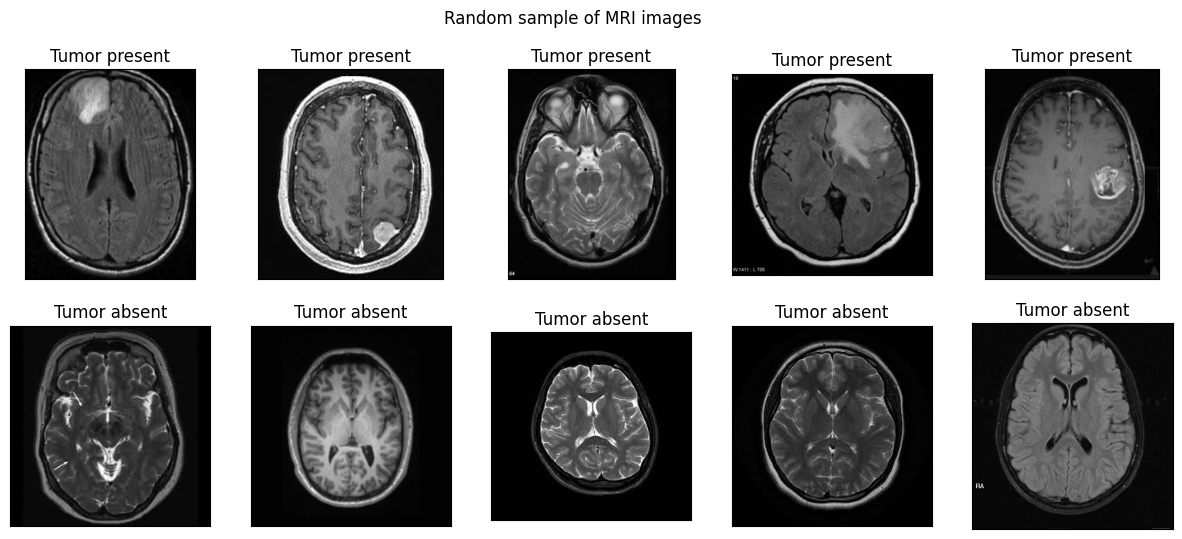

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# set the path to your dataset folder
data_path = "drive/MyDrive/PROJECTS"

# create lists to store the image paths for the "yes" and "no" folders
yes_image_paths = []
no_image_paths = []

# loop through the subfolders and append the image paths to the appropriate list
for folder in os.listdir(data_path):
    if folder == "yes":
        for file in os.listdir(os.path.join(data_path, folder)):
            yes_image_paths.append(os.path.join(data_path, folder, file))
    elif folder == "no":
        for file in os.listdir(os.path.join(data_path, folder)):
            no_image_paths.append(os.path.join(data_path, folder, file))

# randomly select 5 images from each folder
yes_sample = random.sample(yes_image_paths, 5)
no_sample = random.sample(no_image_paths, 5)

# create a 2x5 grid of subplots to display the images
fig, ax = plt.subplots(2, 5, figsize=(15, 6))

# loop through the "yes" images and display them in the first row
for i in range(5):
    img = cv2.imread(yes_sample[i], cv2.IMREAD_GRAYSCALE)
    ax[0][i].imshow(img, cmap="gray")
    ax[0][i].set_title("Tumor present")

# loop through the "no" images and display them in the second row
for i in range(5):
    img = cv2.imread(no_sample[i], cv2.IMREAD_GRAYSCALE)
    ax[1][i].imshow(img, cmap="gray")
    ax[1][i].set_title("Tumor absent")

# remove the x and y ticks from the subplots
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])

# add a title to the figure
fig.suptitle("Random sample of MRI images")

# show the figure
plt.show()


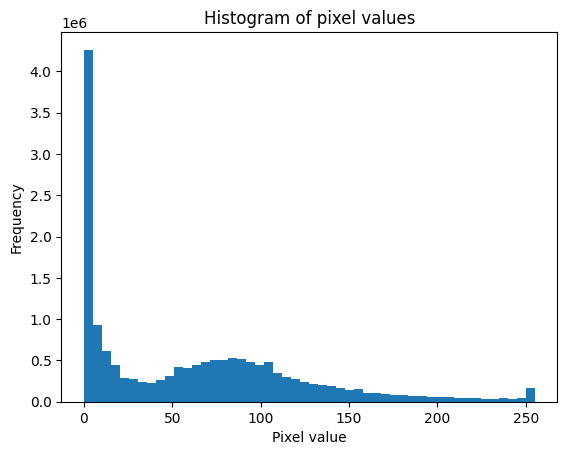

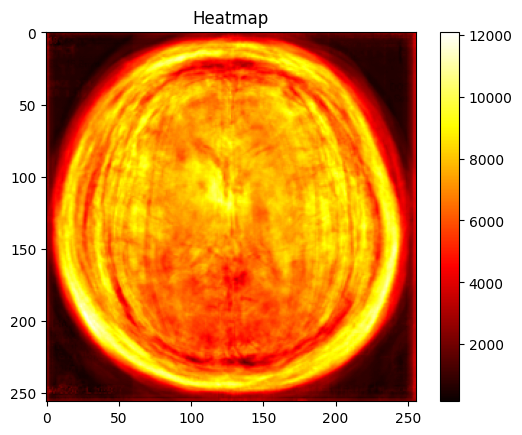

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# set the path to your dataset folder
data_path = "drive/MyDrive/PROJECTS"

# create lists to store the image paths and labels
image_paths = []
labels = []

# loop through the subfolders and append the image paths and labels
for folder in os.listdir(data_path):
    if folder == "yes":
        label = 1
    elif folder == "no":
        label = 0
    else:
        continue
    for file in os.listdir(os.path.join(data_path, folder)):
        image_paths.append(os.path.join(data_path, folder, file))
        labels.append(label)

# create an empty list to store the pixel values
pixel_values = []

# loop through the image paths and read the images
for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # resize the image to 256x256 pixels
    pixel_values.extend(img.flatten())

# plot the histogram
plt.hist(pixel_values, bins=50)
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.title("Histogram of pixel values")
plt.show()

# create an empty array to store the heatmap data
heatmap_data = np.zeros((256, 256))

# loop through the image paths and add the pixel values to the heatmap
for path, label in zip(image_paths, labels):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))  # resize the image to 256x256 pixels
    if label == 1:
        heatmap_data += img
    else:
        heatmap_data -= img

# plot the heatmap
plt.imshow(heatmap_data, cmap='hot')
plt.colorbar()
plt.title("Heatmap")
plt.show()

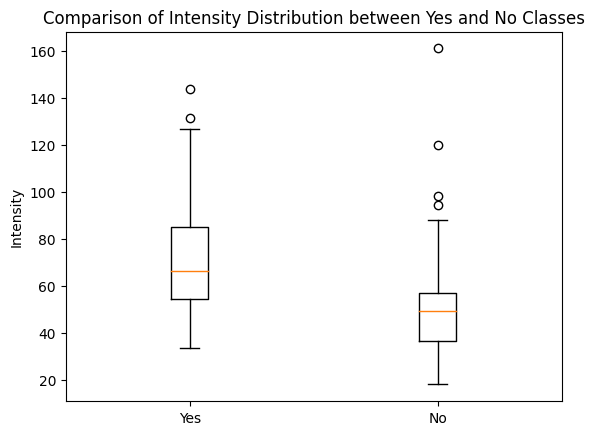

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

# set the path to your dataset folder
data_path = "drive/MyDrive/PROJECTS/brain_tumor_dataset"

# create empty lists to store intensity data
yes_data = []
no_data = []

# iterate through the 'yes' and 'no' folders and extract intensity data
for label in ['yes', 'no']:
    label_path = os.path.join(data_path, label)
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path, img_name)
        img = cv2.imread(img_path, 0)  # read image in grayscale
        intensity = np.mean(img)  # calculate mean intensity
        if label == 'yes':
            yes_data.append(intensity)
        else:
            no_data.append(intensity)

# combine the data
data = [yes_data, no_data]

# create a box plot
fig, ax = plt.subplots()
ax.boxplot(data)

# add labels and title
ax.set_xticklabels(['Yes', 'No'])
ax.set_ylabel('Intensity')
ax.set_title('Comparison of Intensity Distribution between Yes and No Classes')

# show the plot
plt.show()
